# Paleocurrent directions

This notebook applies rotations to paleocurrent trend and plunge measurements to rotate to horizontal based on bedding tilt. These rotated paleocurrent directions are then plotted.

## Import scientific python libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Define functions to apply a tilt correction to paleocurrents

These functions are from the python library ```pmagpy``` and are defined here so that library does not need to be imported.

In [14]:
def dir2cart(d):
    """
    Converts a list or array of vector directions in degrees (declination,
    inclination) to an array of the direction in cartesian coordinates (x,y,z)

    Parameters
    ----------
    d : list or array of [dec,inc] or [dec,inc,intensity]

    Returns
    -------
    cart : array of [x,y,z]

    Examples
    --------
    >>> pmag.dir2cart([200,40,1])
    array([-0.71984631, -0.26200263,  0.64278761])
    """
    ints = np.ones(len(d)).transpose(
    )  # get an array of ones to plug into dec,inc pairs
    d = np.array(d).astype('float')
    rad = np.pi/180.
    if len(d.shape) > 1:  # array of vectors
        decs, incs = d[:, 0] * rad, d[:, 1] * rad
        if d.shape[1] == 3:
            ints = d[:, 2]  # take the given lengths
    else:  # single vector
        decs, incs = np.array(float(d[0])) * rad, np.array(float(d[1])) * rad
        if len(d) == 3:
            ints = np.array(d[2])
        else:
            ints = np.array([1.])
    cart = np.array([ints * np.cos(decs) * np.cos(incs), ints *
                     np.sin(decs) * np.cos(incs), ints * np.sin(incs)])
    cart = np.array([ints * np.cos(decs) * np.cos(incs), ints *
                     np.sin(decs) * np.cos(incs), ints * np.sin(incs)]).transpose()
    return cart

def dotilt(dec, inc, bed_az, bed_dip):
    """
    Does a tilt correction on a direction (dec,inc) using bedding dip direction
    and bedding dip.

    Parameters
    ----------
    dec : declination directions in degrees
    inc : inclination direction in degrees
    bed_az : bedding dip direction
    bed_dip : bedding dip

    Returns
    -------
    dec,inc : a tuple of rotated dec, inc values

    Examples
    -------
    >>> dotilt(91.2,43.1,90.0,20.0)
    (90.952568837153436, 23.103411670066617)
    """
    rad = np.pi / 180.  # converts from degrees to radians
    X = dir2cart([dec, inc, 1.])  # get cartesian coordinates of dec,inc
# get some sines and cosines of new coordinate system
    sa, ca = -np.sin(bed_az * rad), np.cos(bed_az * rad)
    cdp, sdp = np.cos(bed_dip * rad), np.sin(bed_dip * rad)
# do the rotation
    xc = X[0] * (sa * sa + ca * ca * cdp) + X[1] * \
        (ca * sa * (1. - cdp)) + X[2] * sdp * ca
    yc = X[0] * ca * sa * (1. - cdp) + X[1] * \
        (ca * ca + sa * sa * cdp) - X[2] * sa * sdp
    zc = X[0] * ca * sdp - X[1] * sdp * sa - X[2] * cdp
# convert back to direction:
    Dir = cart2dir([xc, yc, -zc])
    # return declination, inclination of rotated direction
    return Dir[0], Dir[1]

def cart2dir(cart):
    """
    Converts a direction in cartesian coordinates into declination, inclinations

    Parameters
    ----------
    cart : input list of [x,y,z] or list of lists [[x1,y1,z1],[x2,y2,z2]...]

    Returns
    -------
    direction_array : returns an array of [declination, inclination, intensity]

    Examples
    --------
    >>> pmag.cart2dir([0,1,0])
    array([ 90.,   0.,   1.])
    """
    cart = np.array(cart)
    rad = np.pi/180.  # constant to convert degrees to radians
    if len(cart.shape) > 1:
        Xs, Ys, Zs = cart[:, 0], cart[:, 1], cart[:, 2]
    else:  # single vector
        Xs, Ys, Zs = cart[0], cart[1], cart[2]
    if np.iscomplexobj(Xs):
        Xs = Xs.real
    if np.iscomplexobj(Ys):
        Ys = Ys.real
    if np.iscomplexobj(Zs):
        Zs = Zs.real
    Rs = np.sqrt(Xs**2 + Ys**2 + Zs**2)  # calculate resultant vector length
    # calculate declination taking care of correct quadrants (arctan2) and
    # making modulo 360.
    Decs = (np.arctan2(Ys, Xs)/rad) % 360.
    try:
        # calculate inclination (converting to degrees) #
        Incs = np.arcsin(Zs/Rs)/rad
    except:
        print('trouble in cart2dir')  # most likely division by zero somewhere
        return np.zeros(3)

    return np.array([Decs, Incs, Rs]).transpose()  # return the directions list

def doflip(dec, inc):
    """
    flips lower hemisphere data to upper hemisphere
    """
    if inc < 0:
        inc = -inc
        dec = (dec + 180.) % 360.
    return dec, inc

In [41]:
paleocurrent_data = pd.read_csv('./data/paleocurrent.csv')
paleocurrent_data.head()

,paleocurrent_trend,paleocurrent_plunge,up_or_down,bedding_dip_direction,bedding_dip,group,note
0,9,49,up,13,52,Nick S-H,flute casts; flow to south
1,40,42,up,6,52,Nick S-H,current ripple; flow to southwest
2,50,53,up,15,57,Nick S-H,current ripple; flow to southwest
3,67,46,up,24,62,Nick S-H,current ripple; flow to southwest
4,60,23,up,21,30,Nick S-H,current ripple; flow to southwest


In [30]:
paleocurrents = []

for n in paleocurrent_data.index:
    if paleocurrent_data.up_or_down[n] == 'up':
        trend = (paleocurrent_data.paleocurrent_trend[n] + 180.0) % 360.0
        plunge = -paleocurrent_data.paleocurrent_plunge[n]
    elif paleocurrent_data.up_or_down[n] == 'down':
        trend = paleocurrent_data.paleocurrent_trend[n]
        plunge = paleocurrent_data.paleocurrent_plunge[n]
    dip_direction = paleocurrent_data.bedding_dip_direction[n]
    dip = paleocurrent_data.bedding_dip[n]
    paleocurrent_trend, paleocurrent_plunge = dotilt(trend,plunge,dip_direction,dip)
    paleocurrents.append(paleocurrent_trend)

In [31]:
paleocurrents

[190.37354831636858,
 210.62574712093743,
 215.1980884650581,
 232.4697302926184,
 236.40838083048968,
 219.54398622872745,
 216.25142448655043,
 225.58104407211195,
 213.16884034500674,
 228.60997453691684,
 197.4841889459029,
 228.94898374535427,
 191.81098844832042,
 203.38475511349893,
 210.6900227403673]

In [32]:
bin_edges = np.arange(0, 370, 10)
number_of_paleocurrents, bin_edges = np.histogram(paleocurrents, bin_edges)

In [33]:
number_of_paleocurrents

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 6,
       3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
bin_edges

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
       260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360])

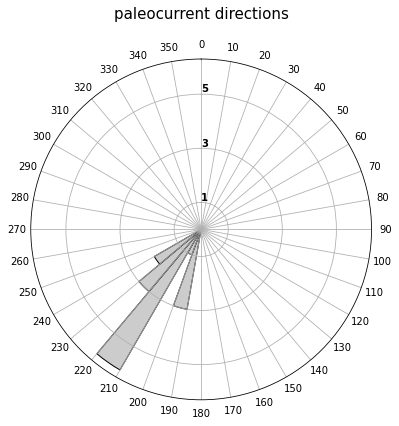

In [40]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1,1,1, projection='polar')

ax.bar(np.deg2rad(np.arange(5, 365, 10)), number_of_paleocurrents, 
       width=np.deg2rad(10), bottom=0.0, color='.8', edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
ax.set_rgrids(np.arange(1, number_of_paleocurrents.max() + 1, 2), angle=0, weight= 'black')
ax.set_title('paleocurrent directions', y=1.10, fontsize=15)

fig.tight_layout()